This Notebook is a python implementation of the model used in the publication "Effect of Temperature on the OH-Stretching Bands of the Methanol
Dimer" Emil Vogt, Casper Vindahl Jensen, and Henrik G. Kjaergaard
The Journal of Physical Chemistry A 2024 128 (2), 392-400
DOI: 10.1021/acs.jpca.3c06456

The script is written by Emil Vogt in May 2024 and editted by Casper Vindahl Jensen.

The model takes the anharmonic transition frequencies, calculated as in the paper but then assumed them to be harmonic wavenumbers. The temperature can be set to any temperature and will output the simulated band profile at that temperature. The E_max option will allow states up to a certain energy to be populated. this option should be adjusted to make sure the band is converged.

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import math
from enum import Enum
import itertools
import time

jax.config.update("jax_enable_x64", True)

In [ ]:
#Approximations made in this script:
# 1) Shifts from low-frequency modes on OHb are additive
# 2) Low-frequency modes are treated as harmonic oscillators
# 3) Transitions are only of the type Delta_v_OHb = 0, Delta_tau = 0 - where tau is a low-freq mode.
#ALL UNITS ARE IN cm-1 - frequency = transition wavenumber

#Define functions:
def Lorentz_(x,Ef,Ei,gamma,T): #Intensity set at exp(-E0/k_bT), where Ei = initial energy
    k_bT = 0.695034800 * T #Thermal energy
    return jnp.exp(-Ei/k_bT) * (0.5 * gamma / jnp.pi) / ((x-Ef)**2 + 0.25 * gamma**2)

#Evaluate with vectorized over x compiled function
Lorentz = jax.jit(jax.vmap(Lorentz_, in_axes=(0,None,None,None,None)))

def Lorentz0K(x,Ef,Ei,gamma,T): #Intensity set at exp(-E0/k_bT), where Ei = initial energy
    k_bT = 0.695034800 * T #Thermal energy
    return (0.5 * gamma / jnp.pi) / ((x-Ef)**2 + 0.25 * gamma**2)

def get_E(vmax, freq, delta, Emax, x, freq_0K, gamma, T):
    if T == 0:
        spec = Lorentz0K(x,freq_0K,0.0,gamma,T)
    else:
        vind = [np.arange(int(nn+1)) for nn in vmax]
        spec = jnp.zeros_like(x)  # Initialize the sum as a zero array of the same shape as x
        for elem in itertools.product(*vind):
            elem_sum_freq = np.sum(np.multiply(elem, freq))
            if elem_sum_freq <= Emax:
                elem_sum_delta = np.sum(np.multiply(elem, delta))
                spec += Lorentz(x, elem_sum_delta + freq_0K, elem_sum_freq, gamma, T)
    return spec

def getFWHM(x,E,indx_max):
    E = E / np.max(E)
    E_left, x_left = E[:indx_max], x[:indx_max]
    E_right, x_right = E[indx_max:], x[indx_max:]
    left_indx = np.argmin(np.abs(E_left-0.5))
    right_indx = np.argmin(np.abs(E_right-0.5))
    return x_right[right_indx] - x_left[left_indx]
#End define functions

freq_OHb = 3541.1 #Frequency of OHb
#Array of transition frequencies for vOHb ground state and excited state
freq_tau0 = jnp.array([26.8,49.1,69.0,109.2,146.6,188.9,317.6,625.3])
freq_tau1 = jnp.array([29.9,54.4,70.1,118.3,149.4,198.5,325.6,673.3])
delta_tau = freq_tau1 - freq_tau0

Nmodes = len(freq_tau0) #Number of low-frequency modes
#Array of delta frequencies for first excited state vs. ground state (0->0 in v_tau, 0->1 in OHb)
delta_OH = jnp.array([1.1,2.0,-3.0,4.2,1.3,2.5,3.0,27.7])
#Frequency of OHb at T=0K
freq_0K = freq_OHb + jnp.sum(delta_OH)

gamma = 8.0 #Lorentzian full width at half-maximum
Emax = 600  #Maximum energy of populated states (depends strongly on temperature!)
x = jnp.linspace(3550,3650,10000) #x_start, x_end, N_points
vmax = jnp.array([np.floor(Emax/freq_tau0[i]) for i in range(Nmodes)]) #Maximum quantum number in each mode
Temperatures = np.linspace(0,100,25) #Temperatures of interest

E = []
start_time = time.time();
for T in Temperatures:
    E.append(get_E(vmax, freq_tau0, delta_tau, Emax, x, freq_0K, gamma, T))
    end_time = time.time()
    print('Calculation for temperature: ',"%.1f" % T,' is finished. Time:',np.round(end_time-start_time),' s')

E = np.transpose(E)
print('Calculations for all temperatures finished')

Calculation for temperature:  0.0  is finished. Time: 0.0  s
Calculation for temperature:  4.2  is finished. Time: 9.0  s
Calculation for temperature:  8.3  is finished. Time: 19.0  s
Calculation for temperature:  12.5  is finished. Time: 27.0  s
Calculation for temperature:  16.7  is finished. Time: 36.0  s
Calculation for temperature:  20.8  is finished. Time: 45.0  s
Calculation for temperature:  25.0  is finished. Time: 53.0  s
Calculation for temperature:  29.2  is finished. Time: 64.0  s
Calculation for temperature:  33.3  is finished. Time: 73.0  s
Calculation for temperature:  37.5  is finished. Time: 82.0  s
Calculation for temperature:  41.7  is finished. Time: 90.0  s
Calculation for temperature:  45.8  is finished. Time: 100.0  s
Calculation for temperature:  50.0  is finished. Time: 111.0  s
Calculation for temperature:  54.2  is finished. Time: 119.0  s
Calculation for temperature:  58.3  is finished. Time: 128.0  s
Calculation for temperature:  62.5  is finished. Time: 1

In [ ]:
#Set font sizes for plot
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Temperature:  0.00  K  Shift in max: 0.003  FWHM: 8.00
Temperature:  4.17  K  Shift in max: 0.003  FWHM: 8.00
Temperature:  8.33  K  Shift in max: 0.013  FWHM: 8.05
Temperature:  12.50  K  Shift in max: 0.063  FWHM: 8.24
Temperature:  16.67  K  Shift in max: 0.143  FWHM: 8.59
Temperature:  20.83  K  Shift in max: 0.253  FWHM: 9.07
Temperature:  25.00  K  Shift in max: 0.383  FWHM: 9.68
Temperature:  29.17  K  Shift in max: 0.533  FWHM: 10.38
Temperature:  33.33  K  Shift in max: 0.703  FWHM: 11.16
Temperature:  37.50  K  Shift in max: 0.903  FWHM: 12.02
Temperature:  41.67  K  Shift in max: 1.133  FWHM: 12.98
Temperature:  45.83  K  Shift in max: 1.413  FWHM: 14.02
Temperature:  50.00  K  Shift in max: 1.773  FWHM: 15.09
Temperature:  54.17  K  Shift in max: 2.233  FWHM: 16.20
Temperature:  58.33  K  Shift in max: 2.803  FWHM: 17.33
Temperature:  62.50  K  Shift in max: 3.433  FWHM: 18.49
Temperature:  66.67  K  Shift in max: 4.083  FWHM: 19.65
Temperature:  70.83  K  Shift in max: 4.7

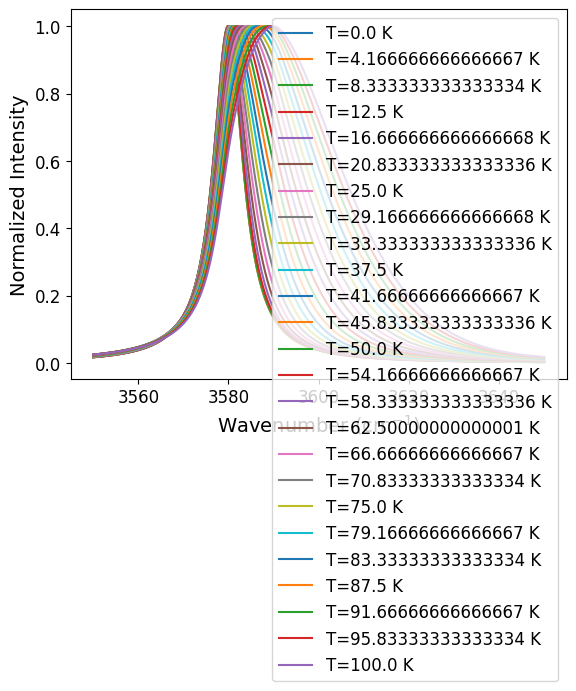

In [ ]:
count = 0
for T in Temperatures:
    plt.plot(x,E[:,count] / np.max(E[:,count]),label='T='+str(T)+' K')
    indx_max = np.argmax(E[:,count])
    x_max = x[indx_max]
    shift = x_max - freq_0K
    FWHM = getFWHM(x,E[:,count],indx_max)
    print('Temperature: ',"%.2f" % T,' K',' Shift in max:', "%.3f" % shift, ' FWHM:', "%.2f" % FWHM)
    count = count + 1

    #MOST IMPORTANT CHECK OF CALCULATIONS!
    #Check if Emax is sufficient for the chosen temperature!
    #E2 should look like E, otherwise the calculation is not converged wrt. Emax!!!
    #E2 = get_E(vmax, freq_tau0, delta_tau, Emax + 100, x, freq_0K, gamma, T)
    #plt.plot(x,E2 / np.max(E2),label='T='+str(T)+' K',s=5)

plt.legend()
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Normalized Intensity');


In [ ]:
count=0
for T in Temperatures:
  indx_max = np.argmax(E[:,count])
  x_max = x[indx_max]
  FWHM = getFWHM(x,E[:,count],indx_max)
  print(str(FWHM) + ",")
  count=count+1



8.000800080008048,
8.000800080008048,
8.050805080507871,
8.240824082407471,
8.590859085908505,
9.070907090709625,
9.680968096809465,
10.381038103810624,
11.161116111611136,
12.02120212021191,
12.981298129812785,
14.021402140214377,
15.091509150915044,
16.201620162016297,
17.33173317331739,
18.491849184918465,
19.65196519651954,
20.832083208320455,
22.022202220222425,
23.232323232323324,
24.42244224422484,
25.582558255825916,
26.692669266926714,
27.762776277627836,
28.82288228822881,


In [ ]:
E[:,1]

array([0.00139926, 0.00140018, 0.0014011 , ..., 0.00025844, 0.00025836,
       0.00025829])